In [1]:
!git clone https://github.com/JustinBakerMath/alignment.git
%cd alignment
!pip3 install -e .

Cloning into 'alignment'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 421 (delta 199), reused 353 (delta 135), pack-reused 0 (from 0)
Receiving objects: 100% (421/421), 120.81 KiB | 698.00 KiB/s, done.
Resolving deltas: 100% (199/199), done.
/content/alignment
Obtaining file:///content/alignment
  Preparing metadata (setup.py) ... done
  Running setup.py develop for torch_canon


In [2]:
!pip install torch_geometric spherical_geometry rdkit py3Dmol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 11.9 MB/s eta 0:00:00


In [3]:
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=537337 sha256=22947363790ec69a6da2d8e328c5e335569ae7ef86d5ecf5e0296018290a4910
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch_sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1111456 sha256=2e135d2047ad4fc2240338d30c209e9b2d8d9e03c95a581487f8c544dad24e9b
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d2

In [4]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.stats import wasserstein_distance_nd

import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader

from torch_canon.pointcloud import CanonEn as Canon

qm9 = QM9(root='../datasets/qm9-2.4.0/')

Extracting ../datasets/qm9-2.4.0/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [03:42<00:00, 600.90it/s]
Done!


In [5]:
qm9

QM9(130831)

In [6]:
qm9[0]

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

Conformer 0: Energy = 3.8533 kcal/mol
Conformer 1: Energy = 3.9460 kcal/mol
Conformer 2: Energy = 3.9460 kcal/mol
Conformer 3: Energy = 3.9601 kcal/mol
Conformer 4: Energy = 3.9460 kcal/mol
Conformer 5: Energy = 5.0669 kcal/mol
Conformer 6: Energy = 4.9378 kcal/mol
Conformer 7: Energy = 3.8303 kcal/mol
Conformer 8: Energy = 5.0669 kcal/mol
Conformer 9: Energy = 3.8533 kcal/mol


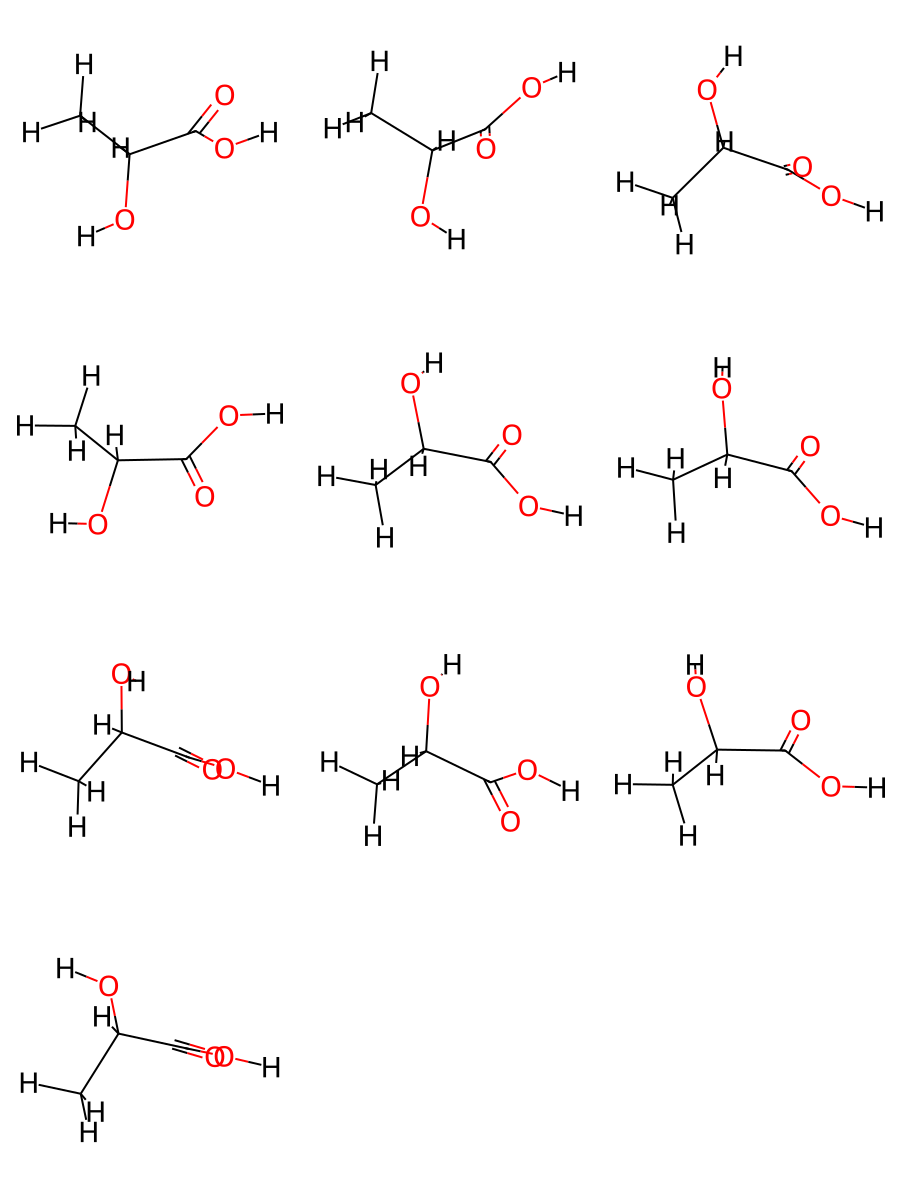

In [270]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolAlign
import numpy as np

# Example SMILES string
smiles = 'CC(C(=O)O)O'  # Ethanol as an example

# Convert SMILES to a molecular object
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)  # Add hydrogen atoms

# Generate multiple conformers
num_conformers = 10  # Number of conformers to generate
params = AllChem.ETKDG()  # Use the ETKDG method for conformer generation
conformer_ids = AllChem.EmbedMultipleConfs(mol, numConfs=num_conformers, params=params)

# Optionally, optimize conformers using force field
AllChem.UFFOptimizeMoleculeConfs(mol)

# Get conformer energies
energies = []
for conf_id in conformer_ids:
    ff = AllChem.UFFGetMoleculeForceField(mol, confId=conf_id)
    energy = ff.CalcEnergy()
    energies.append(energy)

# Print out the energies of conformers
for i, energy in enumerate(energies):
    print(f"Conformer {i}: Energy = {energy:.4f} kcal/mol")

# Align conformers for comparison (optional)
#rdMolAlign.AlignMolConformers(mol)


# Draw all conformers in a grid
Draw.MolsToGridImage([mol] * num_conformers, molsPerRow=3, subImgSize=(300, 300), confIds=conformer_ids)



## Visualize Conformers

In [269]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem

# Generate the molecule and conformers
smiles = 'CC(C(=O)O)O'  # Example: ethanol
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMultipleConfs(mol, numConfs=5)

# Function to visualize a conformer using py3Dmol
def visualize_conformer(mol, conf_id):
    mol_block = Chem.MolToMolBlock(mol, confId=conf_id)
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(mol_block, "sdf")
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    viewer.show()

# Visualize the first conformer
visualize_conformer(mol, conf_id=0)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [287]:
import plotly.graph_objs as go
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolTransforms import GetBondLength
from rdkit.Chem import rdMolDescriptors
from plotly.offline import plot

def plot_conformer(mol, conf_id=0, atom_colors=None, show_atom_labels=True, save_fig = False):
    """
    Plots a 3D visualization of a specific conformer of a molecule with atom colors and bonds.

    Parameters:
    - mol: RDKit molecule object.
    - conf_id: Conformer ID to be visualized (default is 0).
    - atom_colors: Dictionary mapping atomic numbers to colors. If None, uses default colors.
    - show_atom_labels: Boolean to indicate whether to display atom symbols (True) or not (False).
    """
    if atom_colors is None:
        atom_colors = {
            1: 'white',  # Hydrogen
            6: 'black',  # Carbon
            8: 'red'     # Oxygen
        }

    # Get atomic positions for the specified conformer
    conf = mol.GetConformer(conf_id)
    positions = conf.GetPositions()

    # Get atom colors and symbols based on atomic numbers
    atom_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    atom_color_list = [atom_colors.get(num, 'gray') for num in atom_numbers]  # Default to 'gray' if atom not in dict

    # Extract x, y, z coordinates
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

    # Create scatter plot for the atoms
    atom_trace = go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers+text' if show_atom_labels else 'markers',
        marker=dict(size=20, color=atom_color_list, line=dict(width=2)),
        text=atom_symbols if show_atom_labels else None,  # Atom symbols as text if show_atom_labels is True
        hoverinfo='text' if show_atom_labels else 'none'
    )

    # Create the bond traces
    bond_traces = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bond_trace = go.Scatter3d(
            x=[x[i], x[j]], y=[y[i], y[j]], z=[z[i], z[j]],
            mode='lines',
            line=dict(color='gray', width=10),  # Set bond color and width
            hoverinfo='none'  # No hover info on bonds
        )
        bond_traces.append(bond_trace)


    ff = AllChem.UFFGetMoleculeForceField(mol, confId=conf_id)
    energy = ff.CalcEnergy()

    # Create the layout for the plot
    title = f"Molecule: {rdMolDescriptors.CalcMolFormula(mol)}, Conformer (ID: {conf_id})"
    if energy is not None:
        title += f"<br>Energy: {energy:.2f} kcal/mol"  # Add energy to the title
    # Create the layout for the plot
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        )
    )

    # Combine atom and bond traces
    data = [atom_trace] + bond_traces

    # Plot the conformer using Plotly
    fig = go.Figure(data=data, layout=layout)
    if save_fig:
        fig.write_html(f'conformer_{conf_id}.html')

    fig.show()




# Generate the molecule and conformers
#smiles = 'CCO'  # Example: ethanol
#smiles = "CC(C(=O)O)O" # lactic acid
smiles = "C1=CC=C(C=C1)C2=CC=CC=C2"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMultipleConfs(mol, numConfs=20)
rdMolAlign.AlignMolConformers(mol)

plot_conformer(mol, conf_id=0, atom_colors={1: 'white', 6: 'black', 8: 'red'}, save_fig= True)
plot_conformer(mol, conf_id=7, atom_colors={1: 'white', 6: 'black', 8: 'red'}, show_atom_labels= False, save_fig= True)
plot_conformer(mol, conf_id=8, atom_colors={1: 'white', 6: 'black', 8: 'red'}, show_atom_labels= False, save_fig= True)



### Visualize Alignment Results

In [20]:
def plot_conformer_aligned(mol, conf_id=0, atom_colors=None, show_atom_labels=True):
    """
    Plots a 3D visualization of a specific conformer of a molecule with atom colors and bonds.

    Parameters:
    - mol: RDKit molecule object.
    - conf_id: Conformer ID to be visualized (default is 0).
    - atom_colors: Dictionary mapping atomic numbers to colors. If None, uses default colors.
    - show_atom_labels: Boolean to indicate whether to display atom symbols (True) or not (False).
    """
    if atom_colors is None:
        atom_colors = {
            1: 'white',  # Hydrogen
            6: 'black',  # Carbon
            8: 'red'     # Oxygen
        }



    # Get atomic positions for the specified conformer
    conf = mol.GetConformer(conf_id)
    positions = conf.GetPositions()


    # Get atom colors and symbols based on atomic numbers
    atom_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    atom_color_list = [atom_colors.get(num, 'gray') for num in atom_numbers]  # Default to 'gray' if atom not in dict

    frame = Canon(tol=1e-6)
    normalized_positions, frame_R, frame_t = frame.get_frame(positions, np.array(atom_numbers))

    # Extract x, y, z coordinates
    x, y, z = normalized_positions[:, 0], normalized_positions[:, 1], normalized_positions[:, 2]

    # Create scatter plot for the atoms
    atom_trace = go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers+text' if show_atom_labels else 'markers',
        marker=dict(size=10, color=atom_color_list, line=dict(width=2)),
        text=atom_symbols if show_atom_labels else None,  # Atom symbols as text if show_atom_labels is True
        hoverinfo='text' if show_atom_labels else 'none'
    )

    # Create the bond traces
    bond_traces = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bond_trace = go.Scatter3d(
            x=[x[i], x[j]], y=[y[i], y[j]], z=[z[i], z[j]],
            mode='lines',
            line=dict(color='gray', width=5),  # Set bond color and width
            hoverinfo='none'  # No hover info on bonds
        )
        bond_traces.append(bond_trace)

    # Create the layout for the plot
    layout = go.Layout(
        title=f"Molecule Conformer (ID: {conf_id})",
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        )
    )

    # Combine atom and bond traces
    data = [atom_trace] + bond_traces

    # Plot the conformer using Plotly
    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [21]:
plot_conformer_aligned(mol, conf_id=0, atom_colors={1: 'white', 6: 'black', 8: 'red'})
plot_conformer_aligned(mol, conf_id=3, atom_colors={1: 'white', 6: 'black', 8: 'red'}, show_atom_labels= False)



In [67]:
!pip install experiments

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=02c485275f2b97aa2a932e02d37a1dc9802fb17a14d5c8bd9f5bef99205d5759
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


## Message-Passing Mechanism

### SchNet

In [208]:
from typing import Optional

import torch
from torch.nn import functional as F
from torch_geometric.nn import SchNet
from torch_geometric.nn import global_add_pool, global_mean_pool


class SchNetModel(SchNet):
    """
    SchNet model from "Schnet - a deep learning architecture for molecules and materials".

    This class extends the SchNet base class for PyG.
    """
    def __init__(
        self,
        hidden_channels: int = 128,
        in_dim: int = 1,
        out_dim: int = 1,
        num_filters: int = 128,
        num_layers: int = 5,
        num_gaussians: int = 50,
        cutoff: float = 10,
        max_num_neighbors: int = 32,
        pool: str = 'sum'
    ):
        """
        Initializes an instance of the SchNetModel class with the provided parameters.

        Parameters:
        - hidden_channels (int): Number of channels in the hidden layers (default: 128)
        - in_dim (int): Input dimension of the model (default: 1)
        - out_dim (int): Output dimension of the model (default: 1)
        - num_filters (int): Number of filters used in convolutional layers (default: 128)
        - num_layers (int): Number of convolutional layers in the model (default: 6)
        - num_gaussians (int): Number of Gaussian functions used for radial filters (default: 50)
        - cutoff (float): Cutoff distance for interactions (default: 10)
        - max_num_neighbors (int): Maximum number of neighboring atoms to consider (default: 32)
        - pool (str): Global pooling method to be used (default: "sum")
        """
        super().__init__(
            hidden_channels,
            num_filters,
            num_layers,
            num_gaussians,
            cutoff,
            interaction_graph=None,
            max_num_neighbors=max_num_neighbors,
            readout=pool,
            dipole=False,
            mean=None,
            std=None,
            atomref=None
        )

        # Global pooling/readout function
        self.pool = {"mean": global_mean_pool, "sum": global_add_pool}[pool]

        # Overwrite atom embedding and final predictor
        self.lin2 = torch.nn.Linear(hidden_channels // 2, out_dim)

    def forward(self, batch):

        h = self.embedding(batch.atoms)  # (n,) -> (n, d)

        row, col = batch.edge_index
        edge_weight = (batch.pos[row] - batch.pos[col]).norm(dim=-1)
        edge_attr = self.distance_expansion(edge_weight)

        for interaction in self.interactions:
            # # Message passing layer: (n, d) -> (n, d)
            h = h + interaction(h, batch.edge_index, edge_weight, edge_attr)

        out = self.pool(h, batch.batch)  # (n, d) -> (batch_size, d)

        out = self.lin1(out)
        out = self.act(out)
        out = self.lin2(out)  # (batch_size, out_dim)

        return out, h

### EGNN

In [209]:
import torch
from torch.nn import functional as F
from torch.nn import Linear, ReLU, SiLU, Sequential
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool
from torch_scatter import scatter


class EGNNModel(torch.nn.Module):
    """
    E-GNN model from "E(n) Equivariant Graph Neural Networks".
    """
    def __init__(
        self,
        num_layers: int = 5,
        emb_dim: int = 128,
        in_dim: int = 1,
        out_dim: int = 1,
        activation: str = "relu",
        norm: str = "layer",
        aggr: str = "sum",
        pool: str = "sum",
        residual: bool = True,
        equivariant_pred: bool = False
    ):
        """
        Initializes an instance of the EGNNModel class with the provided parameters.

        Parameters:
        - num_layers (int): Number of layers in the model (default: 5)
        - emb_dim (int): Dimension of the node embeddings (default: 128)
        - in_dim (int): Input dimension of the model (default: 1)
        - out_dim (int): Output dimension of the model (default: 1)
        - activation (str): Activation function to be used (default: "relu")
        - norm (str): Normalization method to be used (default: "layer")
        - aggr (str): Aggregation method to be used (default: "sum")
        - pool (str): Global pooling method to be used (default: "sum")
        - residual (bool): Whether to use residual connections (default: True)
        - equivariant_pred (bool): Whether it is an equivariant prediction task (default: False)
        """
        super().__init__()
        self.equivariant_pred = equivariant_pred
        self.residual = residual

        # Embedding lookup for initial node features
        self.emb_in = torch.nn.Embedding(in_dim, emb_dim)

        # Stack of GNN layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(EGNNLayer(emb_dim, activation, norm, aggr))

        # Global pooling/readout function
        self.pool = {"mean": global_mean_pool, "sum": global_add_pool}[pool]

        if self.equivariant_pred:
            # Linear predictor for equivariant tasks using geometric features
            self.pred = torch.nn.Linear(emb_dim + 3, out_dim)
        else:
            # MLP predictor for invariant tasks using only scalar features
            self.pred = torch.nn.Sequential(
                torch.nn.Linear(emb_dim, emb_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(emb_dim, out_dim)
            )

    def forward(self, batch):

        h = self.emb_in(batch.atoms)  # (n,) -> (n, d)
        pos = batch.pos  # (n, 3)

        for conv in self.convs:
            # Message passing layer
            h_update, pos_update = conv(h, pos, batch.edge_index)

            # Update node features (n, d) -> (n, d)
            h = h + h_update if self.residual else h_update

            # Update node coordinates (no residual) (n, 3) -> (n, 3)
            pos = pos_update

        if not self.equivariant_pred:
            # Select only scalars for invariant prediction
            out = self.pool(h, batch.batch)  # (n, d) -> (batch_size, d)
        else:
            out = self.pool(torch.cat([h, pos], dim=-1), batch.batch)

        return self.pred(out),  h # (batch_size, out_dim) and node features




class EGNNLayer(MessagePassing):
    """E(n) Equivariant GNN Layer

    Paper: E(n) Equivariant Graph Neural Networks, Satorras et al.
    """
    def __init__(self, emb_dim, activation="relu", norm="layer", aggr="add"):
        """
        Args:
            emb_dim: (int) - hidden dimension `d`
            activation: (str) - non-linearity within MLPs (swish/relu)
            norm: (str) - normalisation layer (layer/batch)
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.activation = {"swish": SiLU(), "relu": ReLU()}[activation]
        self.norm = {"layer": torch.nn.LayerNorm, "batch": torch.nn.BatchNorm1d}[norm]

        # MLP `\psi_h` for computing messages `m_ij`
        self.mlp_msg = Sequential(
            Linear(2 * emb_dim + 1, emb_dim),
            self.norm(emb_dim),
            self.activation,
            Linear(emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
        )
        # MLP `\psi_x` for computing messages `\overrightarrow{m}_ij`
        self.mlp_pos = Sequential(
            Linear(emb_dim, emb_dim), self.norm(emb_dim), self.activation, Linear(emb_dim, 1)
        )
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        self.mlp_upd = Sequential(
            Linear(2 * emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
            Linear(emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
        )

    def forward(self, h, pos, edge_index):
        """
        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
        Returns:
            out: [(n, d),(n,3)] - updated node features
        """
        out = self.propagate(edge_index, h=h, pos=pos)
        return out

    def message(self, h_i, h_j, pos_i, pos_j):
        # Compute messages
        pos_diff = pos_i - pos_j
        dists = torch.norm(pos_diff, dim=-1).unsqueeze(1)
        msg = torch.cat([h_i, h_j, dists], dim=-1)
        msg = self.mlp_msg(msg)
        # Scale magnitude of displacement vector
        pos_diff = pos_diff * self.mlp_pos(msg)
        # NOTE: some papers divide pos_diff by (dists + 1) to stabilise model.
        # NOTE: lucidrains clamps pos_diff between some [-n, +n], also for stability.
        return msg, pos_diff

    def aggregate(self, inputs, index):
        msgs, pos_diffs = inputs
        # Aggregate messages
        msg_aggr = scatter(msgs, index, dim=self.node_dim, reduce=self.aggr)
        # Aggregate displacement vectors
        pos_aggr = scatter(pos_diffs, index, dim=self.node_dim, reduce="mean")
        return msg_aggr, pos_aggr

    def update(self, aggr_out, h, pos):
        msg_aggr, pos_aggr = aggr_out
        upd_out = self.mlp_upd(torch.cat([h, msg_aggr], dim=-1))
        upd_pos = pos + pos_aggr
        return upd_out, upd_pos

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})"


class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim, activation="relu", norm="layer", aggr="add"):
        """Vanilla Message Passing GNN layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            activation: (str) - non-linearity within MLPs (swish/relu)
            norm: (str) - normalisation layer (layer/batch)
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.activation = {"swish": SiLU(), "relu": ReLU()}[activation]
        self.norm = {"layer": torch.nn.LayerNorm, "batch": torch.nn.BatchNorm1d}[norm]

        # MLP `\psi_h` for computing messages `m_ij`
        self.mlp_msg = Sequential(
            Linear(2 * emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
            Linear(emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
        )
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        self.mlp_upd = Sequential(
            Linear(2 * emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
            Linear(emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
        )

    def forward(self, h, edge_index):
        """
        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h)
        return out

    def message(self, h_i, h_j):
        # Compute messages
        msg = torch.cat([h_i, h_j], dim=-1)
        msg = self.mlp_msg(msg)
        return msg

    def aggregate(self, inputs, index):
        # Aggregate messages
        msg_aggr = scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
        return msg_aggr

    def update(self, aggr_out, h):
        upd_out = self.mlp_upd(torch.cat([h, aggr_out], dim=-1))
        return upd_out

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})"

### MPNN

In [210]:
class MPNNModel(torch.nn.Module):
    """
    E-GNN model from "E(n) Equivariant Graph Neural Networks".
    """
    def __init__(
        self,
        num_layers: int = 5,
        emb_dim: int = 128,
        in_dim: int = 1,
        out_dim: int = 1,
        activation: str = "relu",
        norm: str = "layer",
        aggr: str = "sum",
        pool: str = "sum",
        pos_usage: bool  = False,
        residual: bool = True
    ):
        """
        Initializes an instance of the EGNNModel class with the provided parameters.

        Parameters:
        - num_layers (int): Number of layers in the model (default: 5)
        - emb_dim (int): Dimension of the node embeddings (default: 128)
        - in_dim (int): Input dimension of the model (default: 1)
        - out_dim (int): Output dimension of the model (default: 1)
        - activation (str): Activation function to be used (default: "relu")
        - norm (str): Normalization method to be used (default: "layer")
        - aggr (str): Aggregation method to be used (default: "sum")
        - pool (str): Global pooling method to be used (default: "sum")
        - residual (bool): Whether to use residual connections (default: True)
        - equivariant_pred (bool): Whether it is an equivariant prediction task (default: False)
        """
        super().__init__()
        self.pos_usage = pos_usage
        self.residual = residual

        # Embedding lookup for initial node features
        self.emb_in = torch.nn.Embedding(in_dim, emb_dim)

        if self.pos_usage == True:
            emb_dim = emb_dim + 3
        # Stack of GNN layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, activation, norm, aggr))

        # Global pooling/readout function
        self.pool = {"mean": global_mean_pool, "sum": global_add_pool}[pool]

        # MLP predictor for invariant tasks using only scalar features
        self.pred = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, emb_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(emb_dim, out_dim)
        )

    def forward(self, batch):

        h = self.emb_in(batch.atoms)  # (n,) -> (n, d)
        if self.pos_usage == True:
            pos = batch.pos  # (n, 3)
            h = torch.cat([h, pos], dim=-1)

        for conv in self.convs:
            # Message passing layer
            h_update = conv(h, batch.edge_index)

            # Update node features (n, d) -> (n, d)
            h = h + h_update if self.residual else h_update

        out = self.pool(h, batch.batch)  # (n, d) -> (batch_size, d)

        return self.pred(out),  h # (batch_size, out_dim) and node features

### Comparison: K-chains

tensor([[  1.8321,   5.2489,   1.2474],
        [  0.3304,   0.5479,   0.4440],
        [  0.7805,  -3.3222,   3.5775],
        [  1.2306,  -7.1924,   6.7111],
        [  1.6807, -11.0626,   9.8446],
        [  0.1789, -15.7635,   9.0412]])


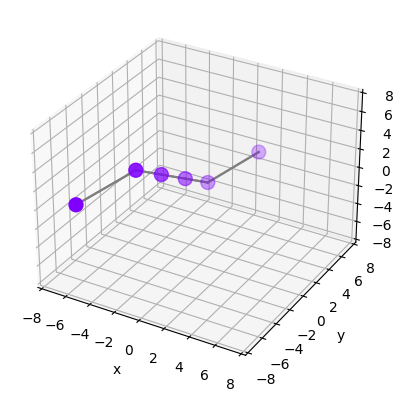

tensor([[ -1.7116,   0.4912,  -4.1197],
        [  0.3304,   0.5479,   0.4440],
        [  0.7805,  -3.3222,   3.5775],
        [  1.2306,  -7.1924,   6.7111],
        [  1.6807, -11.0626,   9.8446],
        [  0.1789, -15.7635,   9.0412]])


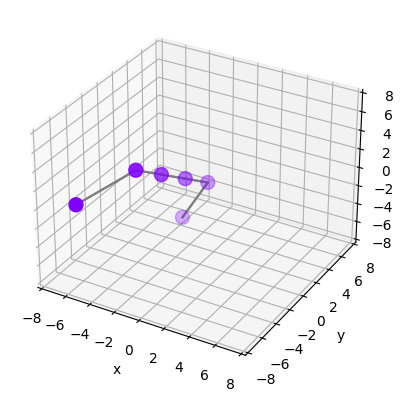

In [68]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_undirected
from functools import partial

from torch_geometric.seed import seed_everything

from experiments.utils.plot_utils import plot_3d

def create_kchains(k,n):
    seed_everything(10)
    assert k >= 2
    assert n >= 1

    dataset = []
    for i in range(n):
      M = torch.rand(3,3)
      Q, _ = torch.linalg.qr(M, mode='complete')
      b = torch.rand(3)

      # Graph 0
      atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
      cell = torch.diag(torch.ones(3,dtype=torch.float)).view(1,3,3)
      edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
      pos = torch.FloatTensor(
          [[-4, -3, 0]] +
          [[0, 5*i , 0] for i in range(k)] +
          [[4, 5*(k-1) + 3, 0]]
      )
      # center_of_mass = torch.mean(pos, dim=0)
      # pos = pos - center_of_mass
      y = torch.LongTensor([0])  # Label gvp0
      # data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
      # data1.edge_index = to_undirected(data1.edge_index)
      # dataset.append(data1)
      transf_pos = [Q@val+b for val in pos]
      transf_pos = torch.vstack(transf_pos)
      data1 = Data(atoms=atoms, edge_index=edge_index, pos=transf_pos, y=y, natoms=k+2, cell=cell)
      data1.edge_index = to_undirected(data1.edge_index)
      dataset.append(data1)

      # Graph 1
      atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
      edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
      pos = torch.FloatTensor(
          [[4, -3, 0]] +
          [[0, 5*i , 0] for i in range(k)] +
          [[4, 5*(k-1) + 3, 0]]
      )
      # center_of_mass = torch.mean(pos, dim=0)
      # pos = pos - center_of_mass
      y = torch.LongTensor([1])  # Label 1
      # data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
      # data2.edge_index = to_undirected(data2.edge_index)
      # dataset.append(data2)
      transf_pos = [Q@val+b for val in pos]
      transf_pos = torch.vstack(transf_pos)
      data2 = Data(atoms=atoms, edge_index=edge_index, pos=transf_pos, y=y, natoms=k+2, cell=cell)
      data2.edge_index = to_undirected(data2.edge_index)
      dataset.append(data2)

    return dataset

# Create dataset
k = 4
dataset = create_kchains(k=k,n=1)
for data in dataset:
    print(data.pos)
    plot_3d(data, lim=2*k)

In [212]:
# Create dataloaders
import random

from experiments.utils.train_utils import run_experiment

total = 50
seed_everything(10)
permuted_g1 = list(range(total))
permuted_g2 = list(range(total))
random.shuffle(permuted_g1)
random.shuffle(permuted_g2)

dataset = create_kchains(k=4, n=total)
train_n = int(.5*total)
train_data = [dataset[2*i+1] for i in permuted_g1[:train_n]]
train_data = train_data + [dataset[2*i] for i in permuted_g1[:train_n]]
dataloader = DataLoader(train_data, batch_size=32, shuffle=True)


In [213]:
import torch.optim as optim
import torch.nn as nn

def train(model, dataloader, epochs=10, lr=0.001, device='cpu', loss_type='mse'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Choose the loss function based on the specified type
    if loss_type == 'mse':
        criterion = nn.MSELoss()
    elif loss_type == 'cross_entropy':
        criterion = nn.CrossEntropyLoss()
    elif loss_type == 'bce':
        criterion = nn.BCELoss()
    else:
        raise ValueError("Invalid loss type. Choose 'mse' or 'cross_entropy'.")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch in dataloader:
            batch = batch.to(device)

            optimizer.zero_grad()
            outputs, h = model(batch)  # Forward pass
            batch.y = batch.y.float()
            # Compute loss
            if loss_type == 'mse':
                # Ensure targets are Float for MSE

                loss = criterion(outputs.view(-1), batch.y)
            elif loss_type == 'cross_entropy':
                # For CrossEntropyLoss, targets must be long integers and outputs should be raw logits
                loss = criterion(outputs, batch.y.long())
            elif loss_type == 'bce':
                # For CrossEntropyLoss, targets must be long integers and outputs should be raw logits
                loss = criterion(outputs.view(-1), batch.y)

            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader)}")

        # Save model weights after each epoch
        torch.save(model.state_dict(), f"model_weights_epoch_{epoch+1}.pth")

    print("Training finished.")

# Example usage
# train(schnet_model, train_loader, epochs=10, lr=0.001, device='cuda', loss_type='cross_entropy')


In [214]:
train(EGNNModel(), dataloader, epochs=10, lr=0.001, device='cpu', loss_type = 'mse')

Epoch 1/10, Loss: 107.8446439653635
Epoch 2/10, Loss: 14.95509386062622
Epoch 3/10, Loss: 13.991843700408936
Epoch 4/10, Loss: 1.0933896899223328
Epoch 5/10, Loss: 2.806022882461548
Epoch 6/10, Loss: 0.5629501789808273
Epoch 7/10, Loss: 1.5894637703895569
Epoch 8/10, Loss: 0.4336964786052704
Epoch 9/10, Loss: 0.8323906064033508
Epoch 10/10, Loss: 0.40053603053092957
Training finished.


In [227]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def low_rank_approximation(node_features, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(node_features)
    return reduced_features


def visualize_node_features_temp(model, dataloader, device='cpu', n_clusters=k+2):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        batch_1 = dataset[0]
        batch_2 = dataset[1]

        # Get node features through Forward pass
        y_1 , node_features_1 = model(batch_1)
        _, node_features_2 = model(batch_2)

        # Concatenate node features from both batches
        node_features = torch.cat([node_features_1, node_features_2], dim=0)

        # Perform low-rank approximation (PCA)
        #reduced_features = low_rank_approximation(node_features, n_components=2)

        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        labels = kmeans.fit_predict(node_features)  # Fit on the original node features


        # Get reduced features and lables for both batches
        reduced_features_1 = reduced_features[:len(batch_1)]
        reduced_features_2 = reduced_features[len(batch_1):]
        labels_1 = labels[:len(batch_1)]
        labels_2 = labels[len(batch_1):]

        # Create a graph for visualization
        G_1 = nx.Graph()
        G_2 = nx.Graph()

        # Add nodes
        for i in range(len(reduced_features_1)):
            G_1.add_node(i, feature=reduced_features_1[i])
        for i in range(len(reduced_features_2)):
            G_2.add_node(i, feature=reduced_features_2[i])

        # Add edges from the batch.edge attribute
        edge_index_1 = batch_1.edge_index.cpu().numpy()  # Convert to numpy array if necessary
        for edge in edge_index_1.T:  # edge_index is usually in shape [2, num_edges]
            G_1.add_edge(edge[0], edge[1])  # Add edges to the graph
        edge_index_2 = batch_2.edge_index.cpu().numpy()
        for edge in edge_index_2.T:
            G_2.add_edge(edge[0], edge[1])


         # Draw the graph using the node positions from batch.pos
        pos_1 = {i: batch_1.pos[i].numpy() for i in range(len(batch_1.pos))}
        pos_2 = {i: batch_2.pos[i].numpy() for i in range(len(batch_2.pos))}

        # Use the labels for coloring
        # nx.draw(G, node_color=labels, with_labels=True, cmap=plt.cm.viridis)
        # plt.show()
        cell = torch.diag(torch.ones(3,dtype=torch.float)).view(1,3,3)
        learned_representation_1 = Data(atoms= torch.from_numpy(labels_1), edge_index=batch_1.edge_index, pos=batch_1.pos, y=batch_1.y, natoms=k+2, cell=cell)
        learned_representation_2 = Data(atoms= torch.from_numpy(labels_2), edge_index=batch_2.edge_index, pos=batch_2.pos, y=batch_2.y, natoms=k+2, cell=cell)
        plot_3d(learned_representation_1, lim=2*k)
        plot_3d(learned_representation_2, lim=2*k)



In [243]:
def visualize_node_features(model, dataloader, device='cpu', data_indices=None, n_clusters=k+2):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # If no indices are provided, default to the first two batches
        if data_indices is None:
            data_indices = [26,27,32,33]

        # Initialize a list to hold node features
        all_node_features = []

        # Iterate through the specified indices to get batches
        for index in data_indices:
            batch = dataset[index].to(device)  # Get the batch from dataset
            _, node_features = model(batch)  # Forward pass to get node features

            # Store the node features for concatenation later
            all_node_features.append(node_features)

        # Concatenate all node features from the selected batches
        node_features = torch.cat(all_node_features, dim=0)

        # Perform low-rank approximation (PCA)
        reduced_features = low_rank_approximation(node_features, n_components=2)

        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        labels = kmeans.fit_predict(node_features.cpu().numpy())  # Fit on the original node features


        # Prepare to plot each selected batch
        start_idx = 0  # To track the starting index for each batch
        for index in data_indices:
            batch = dataset[index].to(device)  # Get the current batch again

            # Get the reduced features and labels for the current batch
            num_nodes = batch.pos.size(0)

            # Get the reduced features and labels for the current batch
            reduced_features_batch = reduced_features[start_idx:start_idx + num_nodes]
            labels_batch = labels[start_idx:start_idx + num_nodes]

            # Update the features and labels for the Data object
            cell = torch.diag(torch.ones(3, dtype=torch.float)).view(1, 3, 3)
            learned_representation = Data(atoms=torch.from_numpy(labels_batch),
                                           edge_index=batch.edge_index,
                                           pos=batch.pos,
                                           y=batch.y,
                                           natoms=n_clusters,
                                           cell=cell)
            plot_3d(learned_representation, lim=2*k)
            # Update start_idx for the next batch
            start_idx += num_nodes


Epoch 1/7, Loss: 65.5867235660553
Epoch 2/7, Loss: 9.437089920043945
Epoch 3/7, Loss: 17.302546501159668
Epoch 4/7, Loss: 1.7587612569332123
Epoch 5/7, Loss: 5.068396806716919
Epoch 6/7, Loss: 2.0610291361808777
Epoch 7/7, Loss: 1.2020656317472458
Training finished.


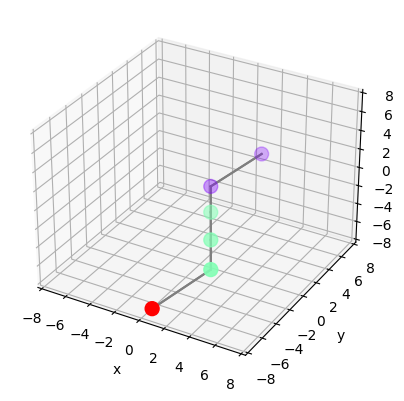

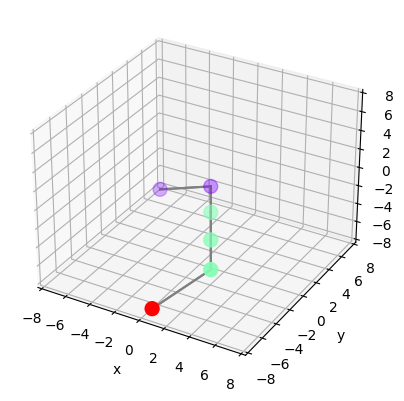

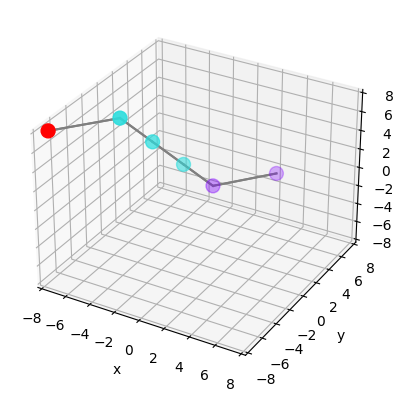

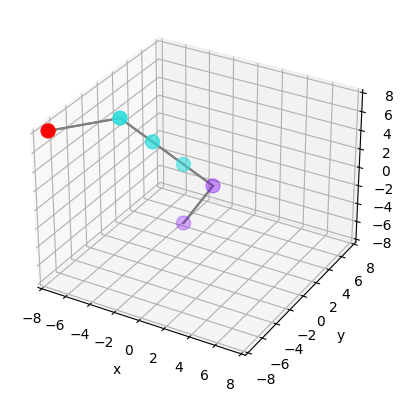

In [256]:
data_indices = [26,27,46, 47]

# Define and train your model
MPNN_pos = MPNNModel(pos_usage=True)  # Create an instance of your model
train(MPNN_pos, dataloader, epochs=7, lr=0.001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(MPNN_pos, dataloader, device='cpu', n_clusters=5, data_indices = data_indices)

Epoch 1/10, Loss: 60.040149450302124
Epoch 2/10, Loss: 10.653466939926147
Epoch 3/10, Loss: 6.021560907363892
Epoch 4/10, Loss: 1.8498983979225159
Epoch 5/10, Loss: 1.0444389134645462
Epoch 6/10, Loss: 1.155175805091858
Epoch 7/10, Loss: 0.9401875734329224
Epoch 8/10, Loss: 0.5403052717447281
Epoch 9/10, Loss: 0.893880695104599
Epoch 10/10, Loss: 0.4003109931945801
Training finished.


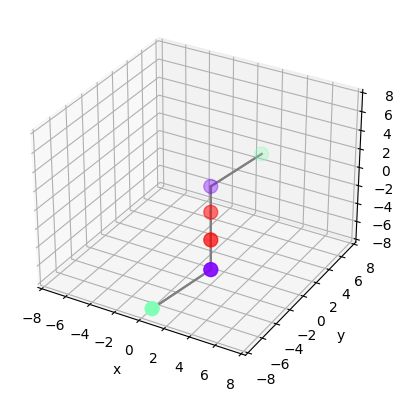

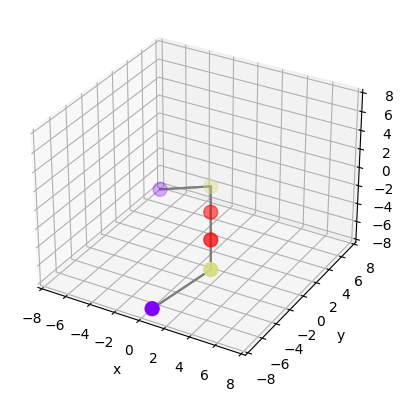

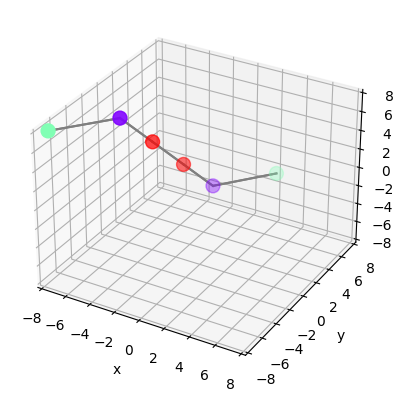

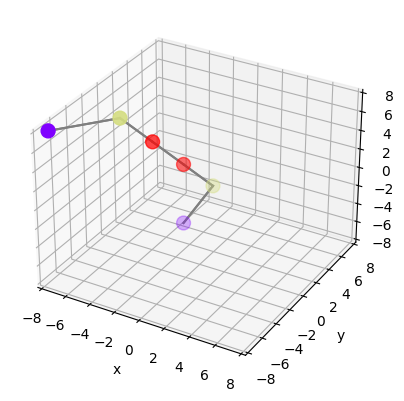

In [258]:
# Define and train your model
EGNN = EGNNModel()  # Create an instance of your model
train(EGNN, dataloader, epochs=10, lr=0.001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(EGNN, dataloader, device='cpu', n_clusters=5, data_indices = data_indices)

Epoch 1/10, Loss: 0.46743203699588776
Epoch 2/10, Loss: 0.2799428701400757
Epoch 3/10, Loss: 0.2755996137857437
Epoch 4/10, Loss: 0.31816598773002625
Epoch 5/10, Loss: 0.26285697519779205
Epoch 6/10, Loss: 0.26535601168870926
Epoch 7/10, Loss: 0.2607369124889374
Epoch 8/10, Loss: 0.27152150869369507
Epoch 9/10, Loss: 0.26240572333335876
Epoch 10/10, Loss: 0.2536876052618027
Training finished.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.



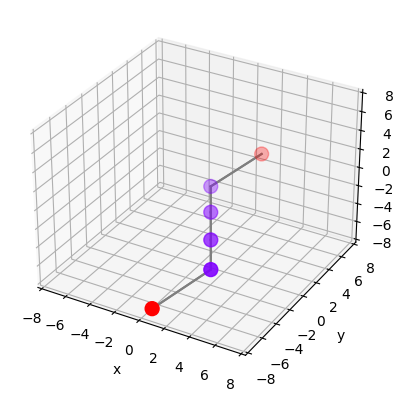

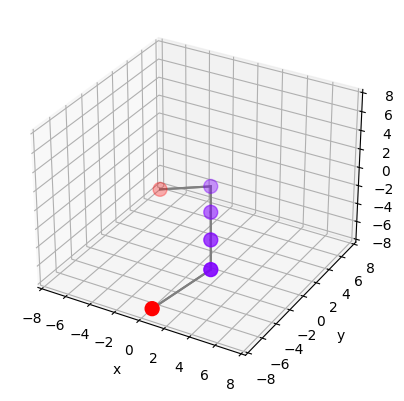

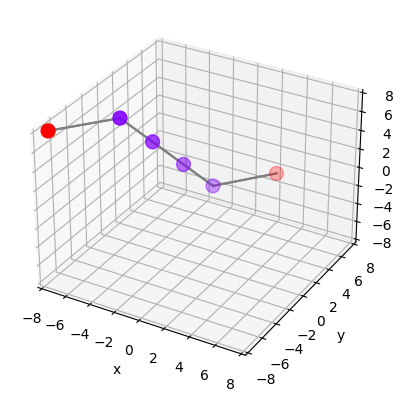

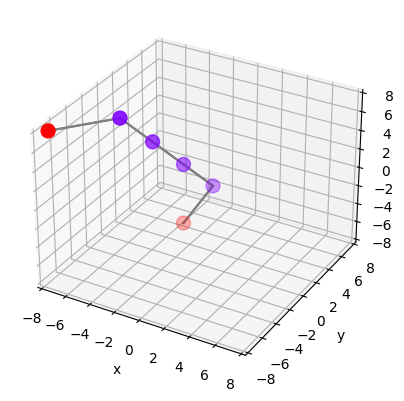

In [259]:
# Define and train your model
SchNet = SchNetModel(cutoff = 5.1)  # Create an instance of your model
train(SchNet, dataloader, epochs=10, lr=0.001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(SchNet, dataloader, device='cpu', n_clusters=5, data_indices = data_indices)

Epoch 1/10, Loss: 64.35048305988312
Epoch 2/10, Loss: 10.917706966400146
Epoch 3/10, Loss: 7.948436260223389
Epoch 4/10, Loss: 2.4346323907375336
Epoch 5/10, Loss: 1.6647629737854004
Epoch 6/10, Loss: 1.0642402470111847
Epoch 7/10, Loss: 1.3606830835342407
Epoch 8/10, Loss: 0.37752676010131836
Epoch 9/10, Loss: 1.0026753842830658
Epoch 10/10, Loss: 0.34066142141819
Training finished.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.



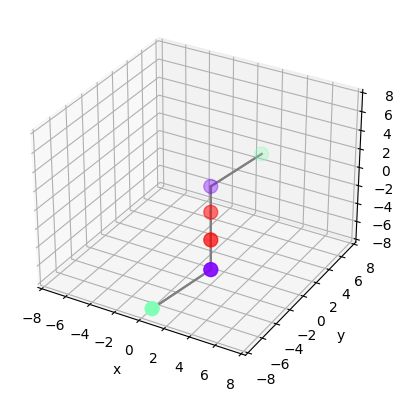

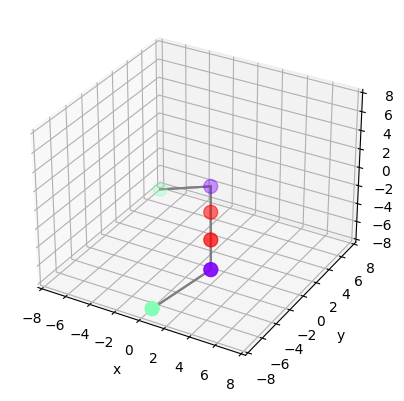

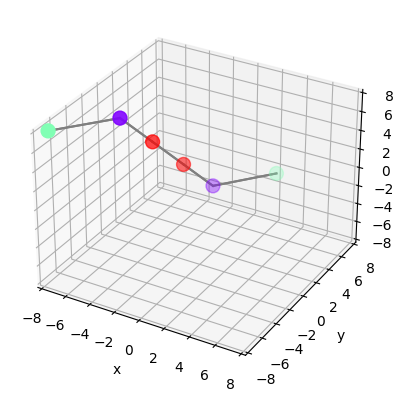

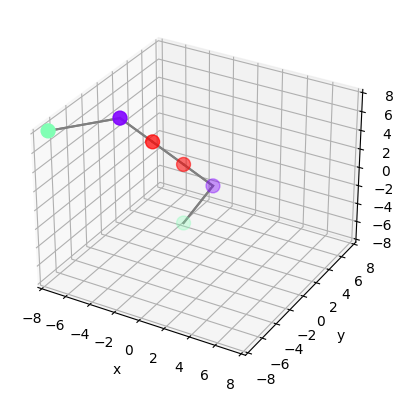

In [260]:
# Define and train your model
MPNN = MPNNModel()  # Create an instance of your model
train(MPNN, dataloader, epochs=10, lr=0.001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(MPNN, dataloader, device='cpu', n_clusters=5, data_indices = data_indices)

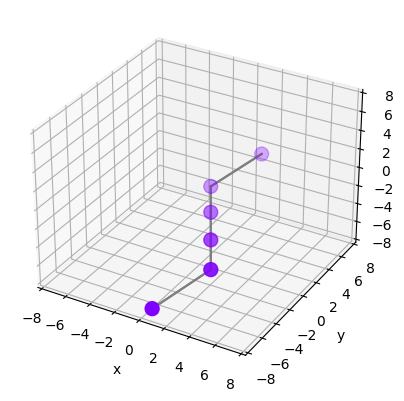

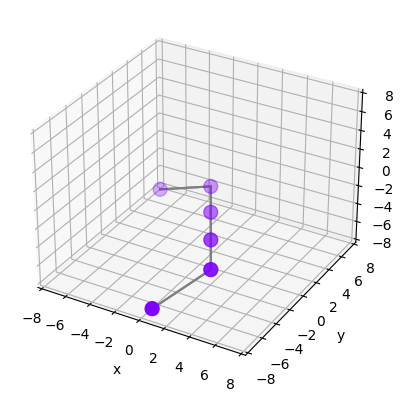

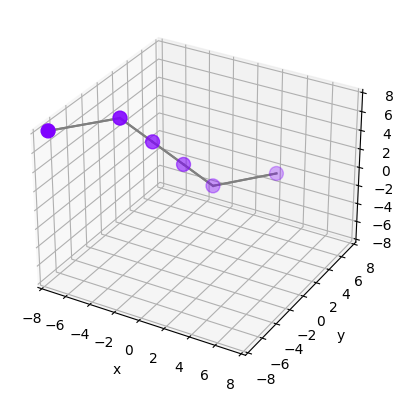

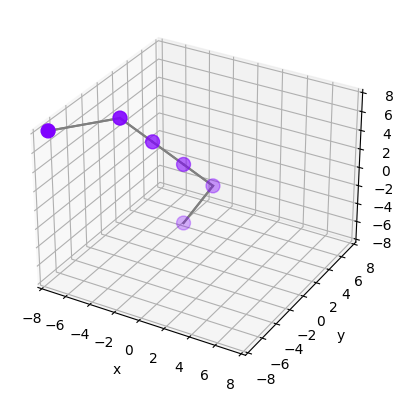

In [261]:
for index in data_indices:
    plot_3d(dataset[index], lim=2*k)


### Comparison: Real Conformers

In [314]:
def visualize_node_features(model, dataset, device='cpu', data_indices=None, n_clusters=k+2):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # If no indices are provided, default to the first two batches
        if data_indices is None:
            data_indices = [26,27,32,33]

        # Initialize a list to hold node features
        all_node_features = []

        # Iterate through the specified indices to get batches
        for index in data_indices:
            batch = dataset[index].to(device)  # Get the batch from dataset
            _, node_features = model(batch)  # Forward pass to get node features

            # Store the node features for concatenation later
            all_node_features.append(node_features)

        # Concatenate all node features from the selected batches
        node_features = torch.cat(all_node_features, dim=0)

        # Perform low-rank approximation (PCA)
        reduced_features = low_rank_approximation(node_features, n_components=2)

        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        labels = kmeans.fit_predict(node_features.cpu().numpy())  # Fit on the original node features


        # Prepare to plot each selected batch
        start_idx = 0  # To track the starting index for each batch
        for index in data_indices:
            batch = dataset[index].to(device)  # Get the current batch again

            # Get the reduced features and labels for the current batch
            num_nodes = batch.pos.size(0)

            # Get the reduced features and labels for the current batch
            reduced_features_batch = reduced_features[start_idx:start_idx + num_nodes]
            labels_batch = labels[start_idx:start_idx + num_nodes]

            # Update the features and labels for the Data object
            cell = torch.diag(torch.ones(3, dtype=torch.float)).view(1, 3, 3)
            learned_representation = Data(atoms=torch.from_numpy(labels_batch),
                                           edge_index=batch.edge_index,
                                           pos=batch.pos,
                                           y=batch.y,
                                           natoms=n_clusters,
                                           cell=cell)
            plot_3d(learned_representation, lim=2*k)
            # Update start_idx for the next batch
            start_idx += num_nodes


In [308]:
# Function to create edge_index from the molecule
def get_edge_index(mol):
    bonds = mol.GetBonds()
    edge_index = []
    for bond in bonds:
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Add reverse edge for undirected graph
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Generate conformers
smiles = "C1=CC=C(C=C1)C2=CC=CC=C2"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMultipleConfs(mol, numConfs=20)
rdMolAlign.AlignMolConformers(mol)

# Iterate over the conformers and store them
conformers_data = []
for conf_id in range(mol.GetNumConformers()):
    # Get atomic positions for the specified conformer
    conf = mol.GetConformer(conf_id)
    positions = conf.GetPositions()

    # Convert positions to a tensor
    transf_pos = torch.tensor(positions, dtype=torch.float)

    # Create edge_index
    edge_index = get_edge_index(mol)

    # Calculate properties (e.g., energy) for the current conformer
    ff = AllChem.UFFGetMoleculeForceField(mol, confId=conf_id)
    energy = ff.CalcEnergy()

    # Replace with your energy calculation or other property extraction logic
    # Example for y: Replace with actual property (e.g., energy)
    y = torch.tensor([energy], dtype=torch.float)

    # Atom information
    atoms = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.long)

    # Define the cell (for periodic systems, if applicable)
    cell = torch.diag(torch.ones(3, dtype=torch.float)).view(1, 3, 3)  # Example for a cubic cell
    natoms = atoms.size(0)  # Number of atoms

    # Create the Data object for this conformer
    data = Data(atoms=atoms, edge_index=edge_index, pos=transf_pos, y=y, natoms = natoms, cell=cell)
    conformers_data.append(data)
    #plot_3d(data)

dataloader_conf = DataLoader(conformers_data, batch_size=5, shuffle=True)

Epoch 1/10, Loss: 2323.4516983032227
Epoch 2/10, Loss: 418.44246768951416
Epoch 3/10, Loss: 154.3819341659546
Epoch 4/10, Loss: 74.68764543533325
Epoch 5/10, Loss: 33.96662425994873
Epoch 6/10, Loss: 22.163753509521484
Epoch 7/10, Loss: 22.197144210338593
Epoch 8/10, Loss: 15.611681580543518
Epoch 9/10, Loss: 12.932803630828857
Epoch 10/10, Loss: 15.634573459625244
Training finished.


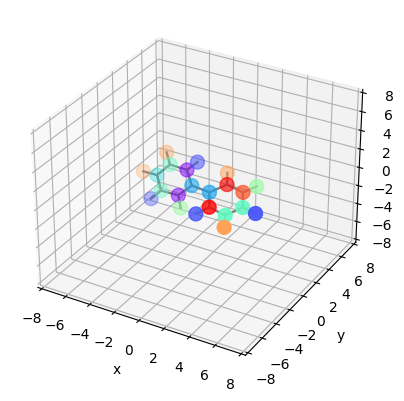

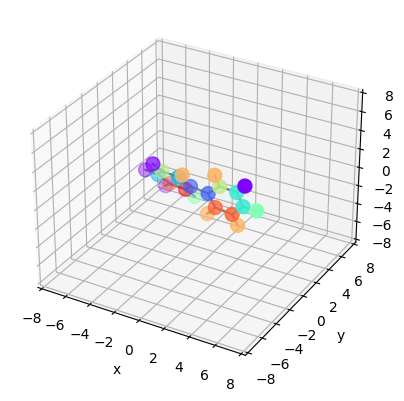

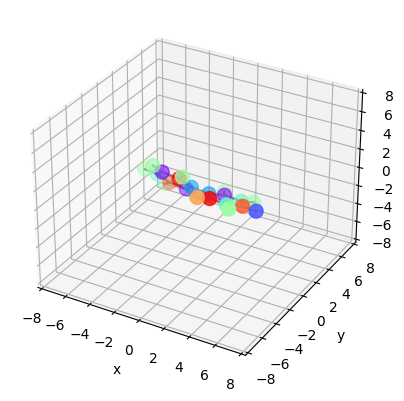

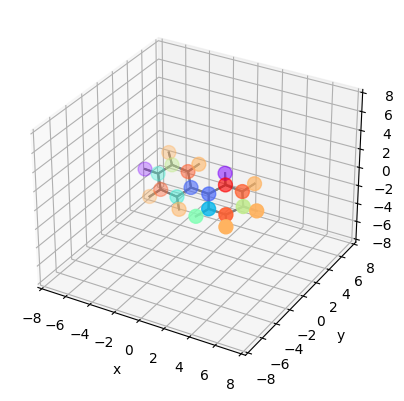

In [321]:
# Define and train your model
EGNN = EGNNModel(in_dim = 7, num_layers= 10)  # Create an instance of your model
train(EGNN, dataloader_conf, epochs=10, lr=0.001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(EGNN, conformers_data, device='cpu', n_clusters=10, data_indices = [0 ,5, 11, 18])


Epoch 1/10, Loss: 1496.5563354492188
Epoch 2/10, Loss: 154.89890003204346
Epoch 3/10, Loss: 68.02575349807739
Epoch 4/10, Loss: 79.21575570106506
Epoch 5/10, Loss: 25.202913284301758
Epoch 6/10, Loss: 22.2230544090271
Epoch 7/10, Loss: 24.194631576538086
Epoch 8/10, Loss: 12.506897270679474
Epoch 9/10, Loss: 18.970274746418
Epoch 10/10, Loss: 10.290295034646988
Training finished.


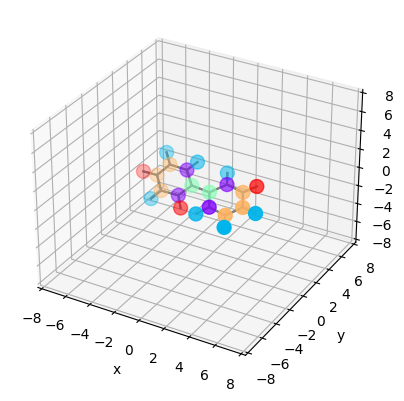

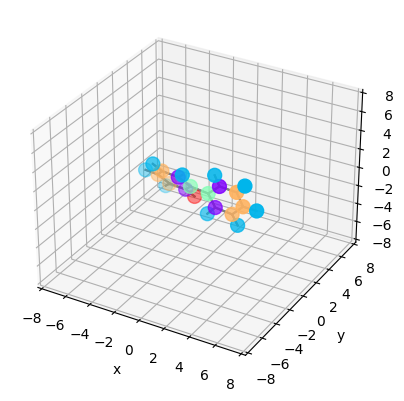

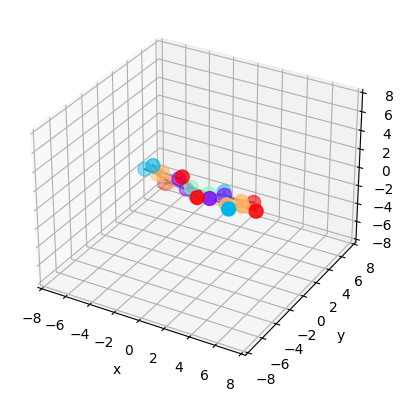

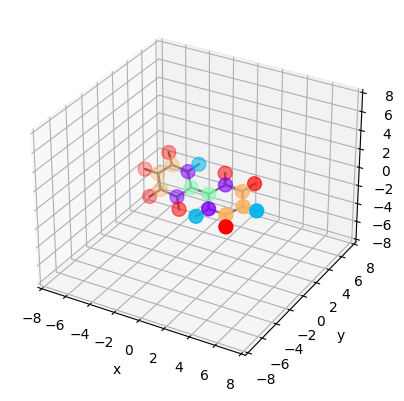

In [323]:
# Define and train your model
Sch = SchNetModel()  # Create an instance of your model
train(Sch, dataloader_conf, epochs=10, lr=0.001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(Sch, conformers_data, device='cpu', n_clusters=5, data_indices = [0 ,5, 11, 18])

Epoch 1/10, Loss: 2170.6631507873535
Epoch 2/10, Loss: 222.41838836669922
Epoch 3/10, Loss: 91.362877368927
Epoch 4/10, Loss: 68.56977081298828
Epoch 5/10, Loss: 38.80637764930725
Epoch 6/10, Loss: 32.02644228935242
Epoch 7/10, Loss: 37.327468395233154
Epoch 8/10, Loss: 23.09026050567627
Epoch 9/10, Loss: 14.28165316581726
Epoch 10/10, Loss: 19.437753915786743
Training finished.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.



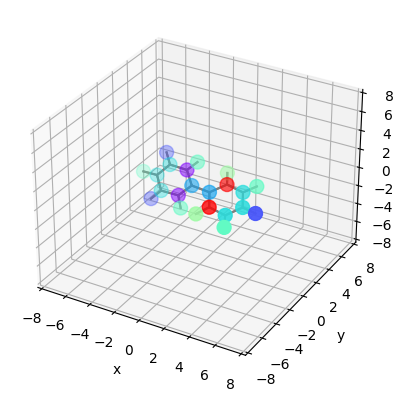

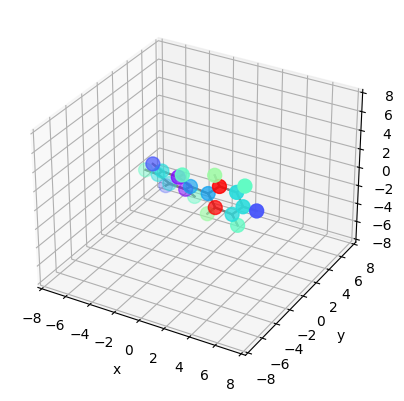

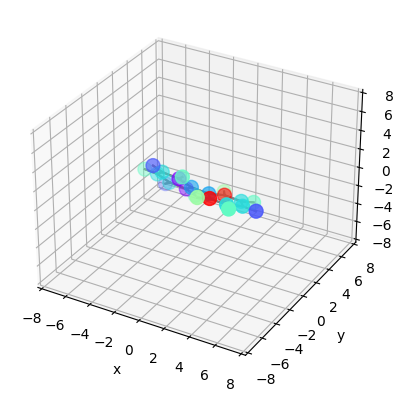

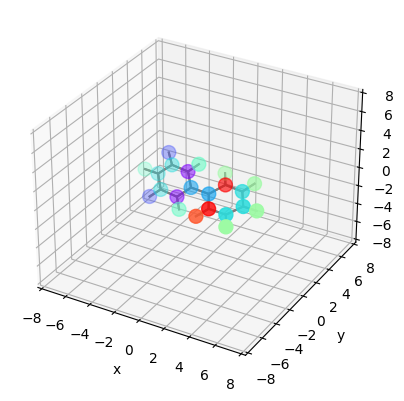

In [324]:
# Define and train your model
MPNN = MPNNModel(in_dim = 7, num_layers= 10)  # Create an instance of your model
train(MPNN, dataloader_conf, epochs=10, lr=0.001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(MPNN, conformers_data, device='cpu', n_clusters=10, data_indices = [0 ,5, 11, 18])

Epoch 1/10, Loss: 1101.9921369552612
Epoch 2/10, Loss: 24.318491280078888
Epoch 3/10, Loss: 39.78604173660278
Epoch 4/10, Loss: 15.263086915016174
Epoch 5/10, Loss: 17.4912850856781
Epoch 6/10, Loss: 18.376851558685303
Epoch 7/10, Loss: 13.695729732513428
Epoch 8/10, Loss: 10.127481877803802
Epoch 9/10, Loss: 13.662638902664185
Epoch 10/10, Loss: 12.329920530319214
Training finished.


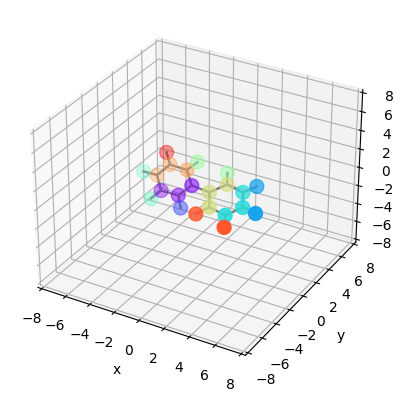

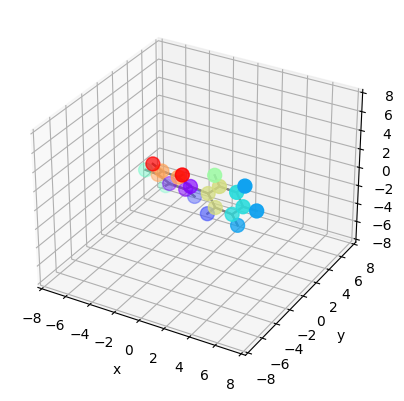

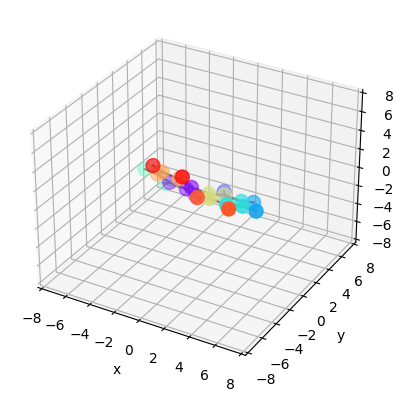

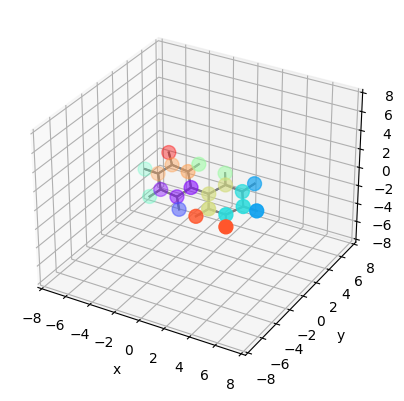

In [325]:
# Define and train your model
MPNN_pos = MPNNModel(in_dim = 7, num_layers= 10, pos_usage= True)  # Create an instance of your model
train(MPNN_pos, dataloader_conf, epochs=10, lr=0.001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(MPNN_pos, conformers_data, device='cpu', n_clusters=10, data_indices = [0 ,5, 11, 18])

### Fragment-Based

In [333]:
# Function to create edge_index from the molecule
def get_edge_index(mol):
    bonds = mol.GetBonds()
    edge_index = []
    for bond in bonds:
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Add reverse edge for undirected graph
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Generate conformers
smiles = "C1=CC=C(C=C1)C2=CC=CC=C2"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMultipleConfs(mol, numConfs=20)
rdMolAlign.AlignMolConformers(mol)


In [345]:
def get_benzene_carbon_lists(mol):
    """
    Extracts two lists of carbon atoms that form the benzene rings from the given molecule.

    Parameters:
    - mol: RDKit molecule object.

    Returns:
    - ring_carbons_1: List of carbon atom indices in the first benzene ring.
    - ring_carbons_2: List of carbon atom indices in the second benzene ring.
    """
    ring_carbons_1 = []
    ring_carbons_2 = []

    # Find all rings in the molecule
    rings = Chem.GetSymmSSSR(mol)

    # Identify benzene rings (6-membered carbon rings)
    for ring in rings:
        if len(ring) == 6:  # Benzene ring has 6 carbon atoms
            if all(mol.GetAtomWithIdx(i).GetAtomicNum() == 6 for i in ring):
                # Check if this is the first or second benzene ring
                if not ring_carbons_1:
                    ring_carbons_1 = list(ring)  # First benzene ring
                else:
                    ring_carbons_2 = list(ring)  # Second benzene ring

    return ring_carbons_1, ring_carbons_2

def get_benzene_connection_indices(mol, ring_carbons_1, ring_carbons_2):
    """
    Gets the indices of the carbon atoms that connect the two benzene rings.

    Parameters:
    - mol: RDKit molecule object.
    - ring_carbons_1: List of carbon atom indices in the first benzene ring.
    - ring_carbons_2: List of carbon atom indices in the second benzene ring.

    Returns:
    - connection_indices: List of carbon atom indices that connect the two benzene rings.
    """
    connection_indices = []

    # Check bonds between the first and second ring's carbon atoms
    for carbon_1 in ring_carbons_1:
        for carbon_2 in ring_carbons_2:
            if mol.GetBondBetweenAtoms(carbon_1, carbon_2):
                connection_indices.append(carbon_1)
                connection_indices.append(carbon_2)

    return connection_indices

In [346]:
# Example usage
smiles = "C1=CC=C(C=C1)C2=CC=CC=C2"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

# Generate conformers as before
AllChem.EmbedMultipleConfs(mol, numConfs=20)
rdMolAlign.AlignMolConformers(mol)

# Get the lists of carbon atoms in the benzene rings
ring_carbons_1, ring_carbons_2 = get_benzene_carbon_lists(mol)

print("Carbon atoms in the first benzene ring:", ring_carbons_1)
print("Carbon atoms in the second benzene ring:", ring_carbons_2)
print("Carbon atoms connecting the two rings:", get_benzene_connection_indices(mol, ring_carbons_1, ring_carbons_2))

Carbon atoms in the first benzene ring: [0, 5, 4, 3, 2, 1]
Carbon atoms in the second benzene ring: [7, 8, 9, 10, 11, 6]
Carbon atoms connecting the two rings: [3, 6]


In [371]:
# Iterate over the conformers and store them
conformers_fragment_data = []
for conf_id in range(mol.GetNumConformers()):
    # Get atomic positions for the specified conformer
    conf = mol.GetConformer(conf_id)
    positions = conf.GetPositions()

    # Convert positions to a tensor
    transf_pos = torch.tensor(positions, dtype=torch.float)

    # Create edge_index
    edge_index = get_edge_index(mol)

    # Calculate properties (e.g., energy) for the current conformer
    ff = AllChem.UFFGetMoleculeForceField(mol, confId=conf_id)
    energy = ff.CalcEnergy()

    # Replace with your energy calculation or other property extraction logic
    # Example for y: Replace with actual property (e.g., energy)
    y = torch.tensor([energy], dtype=torch.float)

    # Atom information
    atoms = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.long)

    # Get the lists of carbon atoms in the benzene rings
    ring_carbons_1, ring_carbons_2 = get_benzene_carbon_lists(mol)
    connections = get_benzene_connection_indices(mol, ring_carbons_1, ring_carbons_2)

    # Add nodes representing fragments
    fragment = torch.zeros(3, dtype=torch.long)
    atoms = torch.cat((atoms, fragment), -1)



    fragment_edges = []

    # Edges from atoms to fragments
    for i in range(len(ring_carbons_1)):
        fragment_edges.append([len(atoms)-3, ring_carbons_1[i]])
        fragment_edges.append([len(atoms)-2, ring_carbons_2[i]])
        fragment_edges.append([ring_carbons_1[i], len(atoms)-3])
        fragment_edges.append([ring_carbons_2[i], len(atoms)-2])

    for i in range(len(connections)):
        fragment_edges.append([len(atoms)-1, connections[i]])
        fragment_edges.append([connections[i], len(atoms)-1])

    # Edges between fragments
    fragment_edges.append([len(atoms)-1, len(atoms)-2])
    fragment_edges.append([len(atoms)-2, len(atoms)-1])
    fragment_edges.append([len(atoms)-1, len(atoms)-3])
    fragment_edges.append([len(atoms)-3, len(atoms)-1])

    edge_index_fragment = torch.as_tensor(np.array(fragment_edges).T)
    edge_index = torch.cat((edge_index, edge_index_fragment), -1)



    # fragment positions
    pos_1 = transf_pos[ring_carbons_1].mean(dim=0)
    pos_2 = transf_pos[ring_carbons_2].mean(dim=0)
    pos_3 = transf_pos[connections].mean(dim=0)
    transf_pos = torch.cat((transf_pos, torch.stack([pos_1, pos_2, pos_3])), 0)

    # Define the cell (for periodic systems, if applicable)
    cell = torch.diag(torch.ones(3, dtype=torch.float)).view(1, 3, 3)  # Example for a cubic cell
    natoms = atoms.size(0)  # Number of atoms


    # Create the Data object for this conformer
    data = Data(atoms=atoms, edge_index=edge_index, pos=transf_pos, y=y, natoms = natoms, cell=cell)
    conformers_fragment_data.append(data)


dataloader_conf_frag = DataLoader(conformers_fragment_data, batch_size=5, shuffle=True)

Epoch 1/30, Loss: 662.5084266662598
Epoch 2/30, Loss: 218.4272117614746
Epoch 3/30, Loss: 55.06359577178955
Epoch 4/30, Loss: 77.99887371063232
Epoch 5/30, Loss: 28.357537746429443
Epoch 6/30, Loss: 41.54704284667969
Epoch 7/30, Loss: 33.93344569206238
Epoch 8/30, Loss: 33.67265498638153
Epoch 9/30, Loss: 26.660147190093994
Epoch 10/30, Loss: 33.26287889480591
Epoch 11/30, Loss: 26.23458194732666
Epoch 12/30, Loss: 31.74163007736206
Epoch 13/30, Loss: 32.223633766174316
Epoch 14/30, Loss: 29.57777500152588
Epoch 15/30, Loss: 24.997268676757812
Epoch 16/30, Loss: 26.61877131462097
Epoch 17/30, Loss: 25.782552242279053
Epoch 18/30, Loss: 27.210242748260498
Epoch 19/30, Loss: 25.859389781951904
Epoch 20/30, Loss: 25.324509143829346
Epoch 21/30, Loss: 26.229024648666382
Epoch 22/30, Loss: 25.209262371063232
Epoch 23/30, Loss: 27.80618941783905
Epoch 24/30, Loss: 26.156184911727905
Epoch 25/30, Loss: 29.266688346862793
Epoch 26/30, Loss: 28.990411043167114
Epoch 27/30, Loss: 26.449151515960

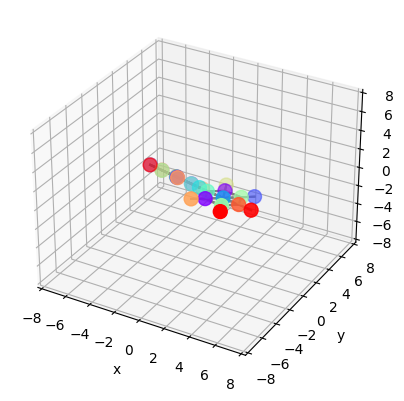

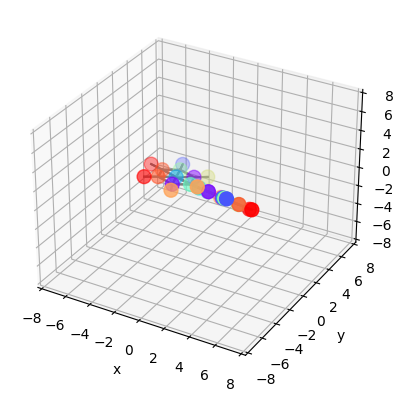

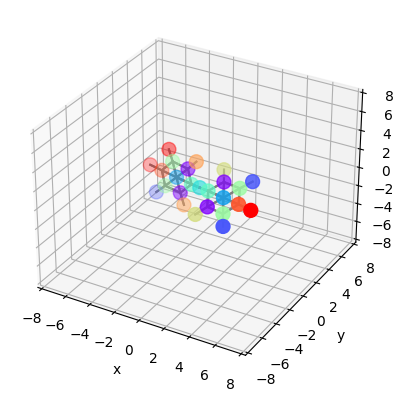

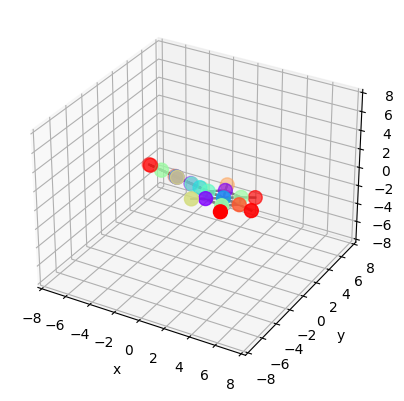

In [370]:
# Define and train your model
EGNN = EGNNModel(in_dim = 7, num_layers= 7)  # Create an instance of your model
train(EGNN, dataloader_conf_frag, epochs=30, lr=0.0001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
visualize_node_features(EGNN, conformers_fragment_data, device='cpu', n_clusters=10, data_indices = [0 ,5, 11, 18])


## EGNN-multiple-channels

In [390]:
# Iterate over the conformers and store them
conformers_fragment_multiple_pos_data = []
for conf_id in range(mol.GetNumConformers()):
    # Get atomic positions for the specified conformer
    conf = mol.GetConformer(conf_id)
    positions = conf.GetPositions()


    # Convert positions to a tensor
    transf_pos = torch.tensor(positions, dtype=torch.float)

    # Create edge_index
    edge_index = get_edge_index(mol)

    # Calculate properties (e.g., energy) for the current conformer
    ff = AllChem.UFFGetMoleculeForceField(mol, confId=conf_id)
    energy = ff.CalcEnergy()

    # Replace with your energy calculation or other property extraction logic
    # Example for y: Replace with actual property (e.g., energy)
    y = torch.tensor([energy], dtype=torch.float)

    # Atom information
    atoms_original = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.long)

    # Get the lists of carbon atoms in the benzene rings
    ring_carbons_1, ring_carbons_2 = get_benzene_carbon_lists(mol)
    connections = get_benzene_connection_indices(mol, ring_carbons_1, ring_carbons_2)

    # Add nodes representing fragments
    fragment = torch.zeros(3, dtype=torch.long)
    atoms = torch.cat((atoms_original, fragment), -1)



    fragment_edges = []

    # Edges from atoms to fragments
    for i in range(len(ring_carbons_1)):
        fragment_edges.append([len(atoms)-3, ring_carbons_1[i]])
        fragment_edges.append([len(atoms)-2, ring_carbons_2[i]])
        fragment_edges.append([ring_carbons_1[i], len(atoms)-3])
        fragment_edges.append([ring_carbons_2[i], len(atoms)-2])

    for i in range(len(connections)):
        fragment_edges.append([len(atoms)-1, connections[i]])
        fragment_edges.append([connections[i], len(atoms)-1])

    # Edges between fragments
    fragment_edges.append([len(atoms)-1, len(atoms)-2])
    fragment_edges.append([len(atoms)-2, len(atoms)-1])
    fragment_edges.append([len(atoms)-1, len(atoms)-3])
    fragment_edges.append([len(atoms)-3, len(atoms)-1])

    edge_index_fragment = torch.as_tensor(np.array(fragment_edges).T)
    edge_index = torch.cat((edge_index, edge_index_fragment), -1)


    # alignment for local frame
    frame = Canon(tol=1e-6)
    _ , frame_R_1, frame_t_1 = frame.get_frame(transf_pos[ring_carbons_1], atoms_original[ring_carbons_1])
    _ , frame_R_2, frame_t_2 = frame.get_frame(transf_pos[ring_carbons_2], atoms_original[ring_carbons_2])
    _ , frame_R_3, frame_t_3 = frame.get_frame(transf_pos[connections], atoms_original[connections])

    frame_R_1 = frame_R_1.T
    frame_R_2 = frame_R_2.T
    frame_R_3 = frame_R_3.T
    # padding zero for preserving shape
    transf_pos = F.pad(transf_pos, (0, 6, 0, 0), mode='constant', value=0)
    transf_pos = torch.cat([transf_pos,
                                  frame_R_1.reshape(1, 9),
                                  frame_R_2.reshape(1, 9),
                                  frame_R_3.reshape(1, 9)],
                                 dim=0)

    # Define the cell (for periodic systems, if applicable)
    cell = torch.diag(torch.ones(3, dtype=torch.float)).view(1, 3, 3)  # Example for a cubic cell
    natoms = atoms.size(0)  # Number of atoms


    # Create the Data object for this conformer
    data = Data(atoms=atoms, edge_index=edge_index, pos=transf_pos, y=y, natoms = natoms, cell=cell)
    conformers_fragment_multiple_pos_data.append(data)


dataloader_conf_frag_multiple_pos = DataLoader(conformers_fragment_multiple_pos_data, batch_size=5, shuffle=True)

In [391]:
# Define and train your model
EGNN = EGNNModel(in_dim = 7, num_layers= 7)  # Create an instance of your model
train(EGNN, dataloader_conf_frag_multiple_pos, epochs=30, lr=0.0001, device='cpu')  # Train the model

# Visualize the learned node features using the trained model
#visualize_node_features(EGNN, conformers_fragment_multiple_pos_data, device='cpu', n_clusters=10, data_indices = [0 ,5, 11, 18])


Epoch 1/30, Loss: 1466.3555450439453
Epoch 2/30, Loss: 45.492398738861084
Epoch 3/30, Loss: 176.48151397705078
Epoch 4/30, Loss: 45.9309983253479
Epoch 5/30, Loss: 46.056411266326904
Epoch 6/30, Loss: 57.38598716259003
Epoch 7/30, Loss: 30.390907764434814
Epoch 8/30, Loss: 38.94735860824585
Epoch 9/30, Loss: 32.96457529067993
Epoch 10/30, Loss: 24.905925273895264
Epoch 11/30, Loss: 28.979713320732117
Epoch 12/30, Loss: 28.106266975402832
Epoch 13/30, Loss: 27.082292079925537
Epoch 14/30, Loss: 26.388797521591187
Epoch 15/30, Loss: 28.907002449035645
Epoch 16/30, Loss: 27.374478936195374
Epoch 17/30, Loss: 25.234042644500732
Epoch 18/30, Loss: 26.34145975112915
Epoch 19/30, Loss: 26.257737159729004
Epoch 20/30, Loss: 25.267380714416504
Epoch 21/30, Loss: 27.63636326789856
Epoch 22/30, Loss: 25.106102108955383
Epoch 23/30, Loss: 26.50999426841736
Epoch 24/30, Loss: 26.97763228416443
Epoch 25/30, Loss: 26.264328479766846
Epoch 26/30, Loss: 26.05429983139038
Epoch 27/30, Loss: 26.111350059